In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data prep & modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.metrics import make_scorer,mean_squared_error, r2_score
import statsmodels.api as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Let us load the data final data set obtained from data cleaning and processing

In [2]:
hpi_df = pd.read_excel('final_hpi_dataframe.xlsx',parse_dates=['observation_date'])

In [3]:
hpi_df.head()

,Unnamed: 0,observation_date,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,Year,Month,Quarter,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
0,0,2003-01-01,128.461,1.24,5.8,10710.4,1654,144.4,2003,1,1,50462,25.93,111278,66.729667,2.270095
1,1,2003-02-01,129.355,1.26,5.9,10674.0,1688,145.2,2003,2,1,50462,25.93,111278,66.729667,2.270095
2,2,2003-03-01,130.148,1.25,5.9,10696.5,1638,145.2,2003,3,1,50462,25.93,111278,66.729667,2.270095
3,3,2003-04-01,130.884,1.26,6.0,10752.7,1662,145.9,2003,4,2,50796,25.93,111278,66.729667,2.270095
4,4,2003-05-01,131.734,1.26,6.1,10832.0,1733,145.8,2003,5,2,50796,25.93,111278,66.729667,2.270095


In [4]:
hpi_df.drop(columns='Unnamed: 0',inplace=True)

#### Let us first make a correlation heat map amongst all the available features.

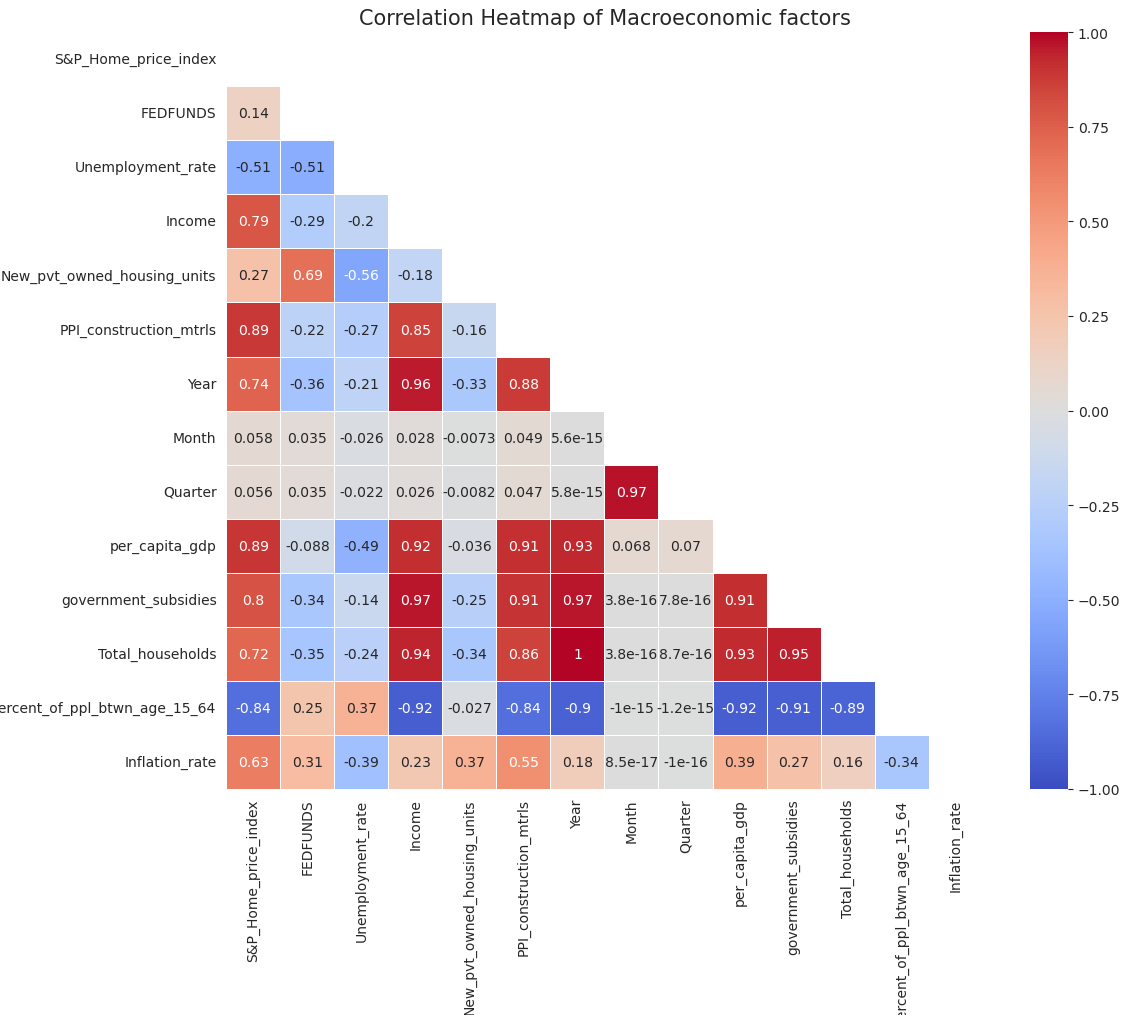

In [5]:
hpi_corr = hpi_df.corr()
mask = np.zeros_like(hpi_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(hpi_corr, mask=mask, vmax=1, vmin=-1, linewidths=.5, square=True, cmap='coolwarm', annot=True)
    plt.title('Correlation Heatmap of Macroeconomic factors', fontsize = 15)
    plt.yticks(rotation=0)
    plt.tight_layout()

### From the correlation heatmap we can see that income, ppi_construction_mtrls,Year of observation, government_subsidies,total_households and inflation_rate show strong positive correlation with S&P home price index.
### Whereas, unemployment rate and percentage of people aged between 15 and 64 show strong negative correlation with S&P home price index.

#### Let us see line chart of each paramter and S&P house price index with respect to time/observation_date.

In [6]:
hpi_df.columns

Index(['observation_date', 'S&P_Home_price_index', 'FEDFUNDS',
       'Unemployment_rate', 'Income', 'New_pvt_owned_housing_units',
       'PPI_construction_mtrls', 'Year', 'Month', 'Quarter', 'per_capita_gdp',
       'government_subsidies', 'Total_households',
       'percent_of_ppl_btwn_age_15_64', 'Inflation_rate'],
      dtype='object')

In [7]:
columns_to_plot = ['FEDFUNDS',
       'Unemployment_rate', 'Income', 'New_pvt_owned_housing_units',
       'PPI_construction_mtrls', 'per_capita_gdp',
       'government_subsidies', 'Total_households',
       'percent_of_ppl_btwn_age_15_64', 'Inflation_rate']
fig, axes = plt.subplots(nrows=int(len(columns_to_plot)), ncols=1, dpi=120, figsize=(40,150))
for i, (col,ax) in enumerate(zip(columns_to_plot, axes.flatten())):
    
    ax.plot(hpi_df['observation_date'],hpi_df[col], marker='o',label =col,color='red')
    ax2=ax.twinx()
    ax2.plot(hpi_df['observation_date'],hpi_df['S&P_Home_price_index'], marker='s',label='S&P_hpi',color='blue')
    ax.legend(fontsize=30)
    ax2.legend(fontsize=30)
    ax.set_title(col)
    ax.tick_params(labelsize=30)
    ax2.tick_params(labelsize=30)
    ax.set_xlabel('TIME', fontsize=30)
    ax.set_ylabel(col, fontsize=30)
    ax2.set_ylabel('S&P_HPI', fontsize=30)


    ax.set_title('{}/S&P HPI vs TIME'.format(col), fontsize=40)
    
    

### From the graphs as well, we can see that our above conclusions for correlations are justified.

Now let us perform the transformation of the Data. We will drop the columns 'observation_date','Year','Month' and 'Quarter'

In [8]:
hpi_model_data = hpi_df.copy()
hpi_model_data = hpi_model_data.drop(columns=['observation_date','Year','Month','Quarter'])
hpi_model_data.head()

,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
0,128.461,1.24,5.8,10710.4,1654,144.4,50462,25.93,111278,66.729667,2.270095
1,129.355,1.26,5.9,10674.0,1688,145.2,50462,25.93,111278,66.729667,2.270095
2,130.148,1.25,5.9,10696.5,1638,145.2,50462,25.93,111278,66.729667,2.270095
3,130.884,1.26,6.0,10752.7,1662,145.9,50796,25.93,111278,66.729667,2.270095
4,131.734,1.26,6.1,10832.0,1733,145.8,50796,25.93,111278,66.729667,2.270095


In [9]:
y =hpi_model_data['S&P_Home_price_index']
X =hpi_model_data.drop(columns=['S&P_Home_price_index'],axis=1)

In [10]:
scaler = MinMaxScaler()
X_transformed=scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, test_size= 0.30, random_state=22)

#### Now let us try out different regression models evaluate their performances

In [12]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

#Below is the dictionary of regression models

models = {'Lasso Regression':Lasso(alpha =1.0),'Ridge Regression':Ridge(alpha=1.0),
          'Bayesian Ridge Regression':BayesianRidge(),'Linear Regression':LinearRegression(),
          'Elastic Net Regression':ElasticNet()}

In [75]:
print('R2 score for different models with all features')
models_and_r2scores={'Model Name':[],'R2 Score':[]}
for model_name,model in models.items():
    r2_accuracy=[]
    for train_index, val_index in cv.split(X_transformed):
        X_train, X_val = X_transformed[train_index], X_transformed[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train,y_train)

        predictions = model.predict(X_val)
        test_accuracy = r2_score(y_val, predictions)
        r2_accuracy.append(test_accuracy)
    models_and_r2scores['Model Name'].append(model_name)
    models_and_r2scores['R2 Score'].append(sum(r2_accuracy)/len(r2_accuracy))
performance_df = pd.DataFrame(models_and_r2scores)
performance_df

R2 score for different models with all features


,Model Name,R2 Score
0,Lasso Regression,0.934732
1,Ridge Regression,0.965788
2,Bayesian Ridge Regression,0.979030
3,Linear Regression,0.978968
4,Elastic Net Regression,0.531853


### We can see that Lasso regression, ridge regression, Bayesian ridge regression and linear regression perform really well with cross validation and show good mean R2 score for the test Data

Let us try to see the performances of the above models without the variables that show weak correlation with S&P House price index.
From the correlation heat map we can see that these parameters are 'FEDFUNDS' and 'New_pvt_owned_housing_units'

In [14]:
y =hpi_model_data['S&P_Home_price_index']
X1 =hpi_model_data.drop(columns=['S&P_Home_price_index','FEDFUNDS','New_pvt_owned_housing_units'],axis=1)

In [15]:
scaler = MinMaxScaler()
X1_transformed=scaler.fit_transform(X1)

In [16]:
models = {'Lasso Regression':Lasso(alpha =1.0),'Ridge Regression':Ridge(alpha=1.0),
          'Bayesian Ridge Regression':BayesianRidge(),'Linear Regression':LinearRegression(),
          'Elastic Net Regression':ElasticNet()}

In [76]:
print('R2 score for different models excluding weakly correlated features')
models_and_r2scores={'Model Name':[],'R2 Score':[]}
for model_name,model in models.items():
    r2_accuracy=[]
    for train_index, val_index in cv.split(X1_transformed):
        X1_train, X1_val = X1_transformed[train_index], X1_transformed[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X1_train,y_train)

        predictions = model.predict(X1_val)
        test_accuracy = r2_score(y_val, predictions)
        r2_accuracy.append(test_accuracy)
    models_and_r2scores['Model Name'].append(model_name)
    models_and_r2scores['R2 Score'].append(sum(r2_accuracy)/len(r2_accuracy))
performance_df = pd.DataFrame(models_and_r2scores)
performance_df

R2 score for different models excluding weakly correlated features


,Model Name,R2 Score
0,Lasso Regression,0.861239
1,Ridge Regression,0.910704
2,Bayesian Ridge Regression,0.927511
3,Linear Regression,0.926143
4,Elastic Net Regression,0.503401


#### IF we observe the performance of every model has been slightly reduced after the removal of weakly correlated variables.

### Now, the data that we have is a time series data. So,we also need to check for the causality of the models as correlation does not explains causality. This would further help us to build a Time-Series model

## Causality Investigation

 First, we use Granger Causality Test to investigate causality of data. Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series. In the MTS, we will test the causality of all combinations of pairs of variables.

 The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y, so the x does not cause y. We use grangercausalitytests function in the package statsmodels to do the test and the output of the matrix is the minimum p-value when computes the test for all lags up to maxlag. The critical value we use is 5% and if the p-value of a pair of variables is smaller than 0.05, we could say with 95% confidence that a predictor x causes a response y.

In [18]:
hpi_timeseries_data = hpi_model_data.copy()
hpi_timeseries_data.head()

,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
0,128.461,1.24,5.8,10710.4,1654,144.4,50462,25.93,111278,66.729667,2.270095
1,129.355,1.26,5.9,10674.0,1688,145.2,50462,25.93,111278,66.729667,2.270095
2,130.148,1.25,5.9,10696.5,1638,145.2,50462,25.93,111278,66.729667,2.270095
3,130.884,1.26,6.0,10752.7,1662,145.9,50796,25.93,111278,66.729667,2.270095
4,131.734,1.26,6.1,10832.0,1733,145.8,50796,25.93,111278,66.729667,2.270095


In [19]:
from statsmodels.tsa.stattools import grangercausalitytests

In [20]:
variables=hpi_timeseries_data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables,index=variables)
for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(hpi_timeseries_data[[row, col]], maxlag=20, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(20)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var[0:4] + '_x' for var in variables]
matrix.index = [var[0:4] + '_y' for var in variables]
print(pd.DataFrame(matrix))

        S&P__x  FEDF_x  Unem_x  Inco_x  New__x  PPI__x  per__x  gove_x  \
S&P__y  1.0000  0.0000  0.0320  0.0000  0.0000  0.0000  0.0066  0.0012   
FEDF_y  0.0000  1.0000  0.0055  0.0160  0.0000  0.0001  0.0177  0.0000   
Unem_y  0.0249  0.0000  1.0000  0.1470  0.0162  0.1940  0.0000  0.0000   
Inco_y  0.0609  0.0000  0.0000  1.0000  0.0209  0.0000  0.0000  0.0000   
New__y  0.0000  0.0001  0.1101  0.4884  1.0000  0.0117  0.2582  0.6457   
PPI__y  0.0000  0.0033  0.0000  0.0000  0.0681  1.0000  0.0000  0.0000   
per__y  0.0494  0.0000  0.0000  0.0000  0.0072  0.1263  1.0000  0.0000   
gove_y  0.3490  0.0121  0.2729  0.0079  0.4034  0.2736  0.0364  1.0000   
Tota_y  0.0001  0.2400  0.0008  0.0013  0.1704  0.0006  0.0000  0.6451   
perc_y  0.0000  0.0067  0.0371  0.0000  0.0000  0.0445  0.0211  0.0000   
Infl_y  0.0005  0.0000  0.0000  0.0000  0.3345  0.0000  0.0000  0.0001   

        Tota_x  perc_x  Infl_x  
S&P__y  0.0000  0.0000  0.0000  
FEDF_y  0.0680  0.0007  0.0000  
Unem_y  0.05

#### If we see all the diagonal values correspond to 1.00 . If we see the first row, we observe that every value is less than 0.05. Which means change in every '_x'_ causes a change in S&P House Price Index though the vice versa may or may not be true.

In [24]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in hpi_timeseries_data.iteritems():
    adfuller_test(column, name=column.name)

 S&P_Home_price_index : P-Value = 0.853 => Non-stationary.
 FEDFUNDS : P-Value = 0.169 => Non-stationary.
 Unemployment_rate : P-Value = 0.082 => Non-stationary.
 Income : P-Value = 0.867 => Non-stationary.
 New_pvt_owned_housing_units : P-Value = 0.187 => Non-stationary.
 PPI_construction_mtrls : P-Value = 0.967 => Non-stationary.
 per_capita_gdp : P-Value = 0.93 => Non-stationary.
 government_subsidies : P-Value = 0.944 => Non-stationary.
 Total_households : P-Value = 0.936 => Non-stationary.
 percent_of_ppl_btwn_age_15_64 : P-Value = 0.903 => Non-stationary.
 Inflation_rate : P-Value = 0.761 => Non-stationary.


#### From the results above, we could see none of these varibles is stationary. Let us use the differencing method to make them stationary.

In [25]:
data_differenced = hpi_timeseries_data.diff().dropna()
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)

 S&P_Home_price_index : P-Value = 0.031 => Stationary. 
 FEDFUNDS : P-Value = 0.09 => Non-stationary.
 Unemployment_rate : P-Value = 0.0 => Stationary. 
 Income : P-Value = 0.003 => Stationary. 
 New_pvt_owned_housing_units : P-Value = 0.25 => Non-stationary.
 PPI_construction_mtrls : P-Value = 0.001 => Stationary. 
 per_capita_gdp : P-Value = 0.0 => Stationary. 
 government_subsidies : P-Value = 0.0 => Stationary. 
 Total_households : P-Value = 0.018 => Stationary. 
 percent_of_ppl_btwn_age_15_64 : P-Value = 0.371 => Non-stationary.
 Inflation_rate : P-Value = 0.0 => Stationary. 


#### Let us do the second differencing:

In [26]:
data_differenced2 = data_differenced.diff().dropna()
for name, column in data_differenced2.iteritems():
    adfuller_test(column, name=column.name)

 S&P_Home_price_index : P-Value = 0.113 => Non-stationary.
 FEDFUNDS : P-Value = 0.0 => Stationary. 
 Unemployment_rate : P-Value = 0.0 => Stationary. 
 Income : P-Value = 0.0 => Stationary. 
 New_pvt_owned_housing_units : P-Value = 0.0 => Stationary. 
 PPI_construction_mtrls : P-Value = 0.0 => Stationary. 
 per_capita_gdp : P-Value = 0.0 => Stationary. 
 government_subsidies : P-Value = 0.0 => Stationary. 
 Total_households : P-Value = 0.0 => Stationary. 
 percent_of_ppl_btwn_age_15_64 : P-Value = 0.0 => Stationary. 
 Inflation_rate : P-Value = 0.0 => Stationary. 


#### Let us do the third differencing:

In [31]:
data_differenced3 = data_differenced2.diff().dropna()
for name, column in data_differenced3.iteritems():
    adfuller_test(column, name=column.name)

 S&P_Home_price_index : P-Value = 0.0 => Stationary. 
 FEDFUNDS : P-Value = 0.0 => Stationary. 
 Unemployment_rate : P-Value = 0.0 => Stationary. 
 Income : P-Value = 0.0 => Stationary. 
 New_pvt_owned_housing_units : P-Value = 0.0 => Stationary. 
 PPI_construction_mtrls : P-Value = 0.0 => Stationary. 
 per_capita_gdp : P-Value = 0.0 => Stationary. 
 government_subsidies : P-Value = 0.0 => Stationary. 
 Total_households : P-Value = 0.0 => Stationary. 
 percent_of_ppl_btwn_age_15_64 : P-Value = 0.0 => Stationary. 
 Inflation_rate : P-Value = 0.0 => Stationary. 


 #### All the time series are now stationary and the degree of differencing is 3 that could be used in the model building in the next step.

Let us do the the train test split first.

In [27]:
print(hpi_timeseries_data.shape)

(240, 11)


In [28]:
df_train = hpi_timeseries_data.head(200)
print(df_train.shape)
df_train.head()

(200, 11)


,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
0,128.461,1.24,5.8,10710.4,1654,144.4,50462,25.93,111278,66.729667,2.270095
1,129.355,1.26,5.9,10674.0,1688,145.2,50462,25.93,111278,66.729667,2.270095
2,130.148,1.25,5.9,10696.5,1638,145.2,50462,25.93,111278,66.729667,2.270095
3,130.884,1.26,6.0,10752.7,1662,145.9,50796,25.93,111278,66.729667,2.270095
4,131.734,1.26,6.1,10832.0,1733,145.8,50796,25.93,111278,66.729667,2.270095


In [29]:
df_test = hpi_timeseries_data.tail(40)
print(df_test.shape)
df_test.head()

(40, 11)


,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
200,210.934,2.04,3.5,15691.3,1150,234.4,62945,40.185,128579,65.472299,1.812210
201,211.844,1.83,3.6,15718.1,1294,233.8,63257,40.185,128579,65.472299,1.812210
202,212.817,1.55,3.6,15778.2,1244,232.8,63257,40.185,128579,65.472299,1.812210
203,213.938,1.55,3.6,15684.8,1310,232.2,63257,40.185,128579,65.472299,1.812210
204,214.954,1.55,3.5,15852.5,1302,233.4,62333,44.147,128451,65.265250,1.233584







### Let’s invoke a VAR() function from statsmodels to build a model of Multivariate-time series in this section.

In [67]:
from statsmodels.tsa.api import VAR

# Assuming 'data' is a DataFrame containing multiple time series variables
model = VAR(hpi_timeseries_data)
results = model.fit(3)

#### Let us check the predictions and create the predictions data frame.

In [68]:
predictions = pd.DataFrame(results.forecast(df_train.values[-3:],steps=40))

In [69]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,10
0,211.136833,1.949884,4.539312,15913.609251,1249.456946,234.272775,62248.815317,40.358022,128659.915618,65.460747,1.961794
1,212.108555,1.820738,4.443872,15939.266319,1232.707300,234.006821,62342.152531,40.737801,128835.103951,65.424556,2.145941
2,213.099661,1.678199,4.397604,16064.314305,1248.183973,234.544464,62308.295049,41.093162,128953.300945,65.401297,2.215712
3,214.205895,1.535446,4.492792,16192.245128,1249.232232,236.205242,62464.000042,41.404568,129042.166398,65.381979,2.209720
4,215.417305,1.403663,4.651924,16226.014868,1244.841541,238.457146,62481.391270,41.636347,129110.429199,65.360542,2.255834


In [70]:
predictions.columns=df_test.columns
predictions.head()

,S&P_Home_price_index,FEDFUNDS,Unemployment_rate,Income,New_pvt_owned_housing_units,PPI_construction_mtrls,per_capita_gdp,government_subsidies,Total_households,percent_of_ppl_btwn_age_15_64,Inflation_rate
0,211.136833,1.949884,4.539312,15913.609251,1249.456946,234.272775,62248.815317,40.358022,128659.915618,65.460747,1.961794
1,212.108555,1.820738,4.443872,15939.266319,1232.707300,234.006821,62342.152531,40.737801,128835.103951,65.424556,2.145941
2,213.099661,1.678199,4.397604,16064.314305,1248.183973,234.544464,62308.295049,41.093162,128953.300945,65.401297,2.215712
3,214.205895,1.535446,4.492792,16192.245128,1249.232232,236.205242,62464.000042,41.404568,129042.166398,65.381979,2.209720
4,215.417305,1.403663,4.651924,16226.014868,1244.841541,238.457146,62481.391270,41.636347,129110.429199,65.360542,2.255834



#### Let us plot the actual values and the predicted values on a graph


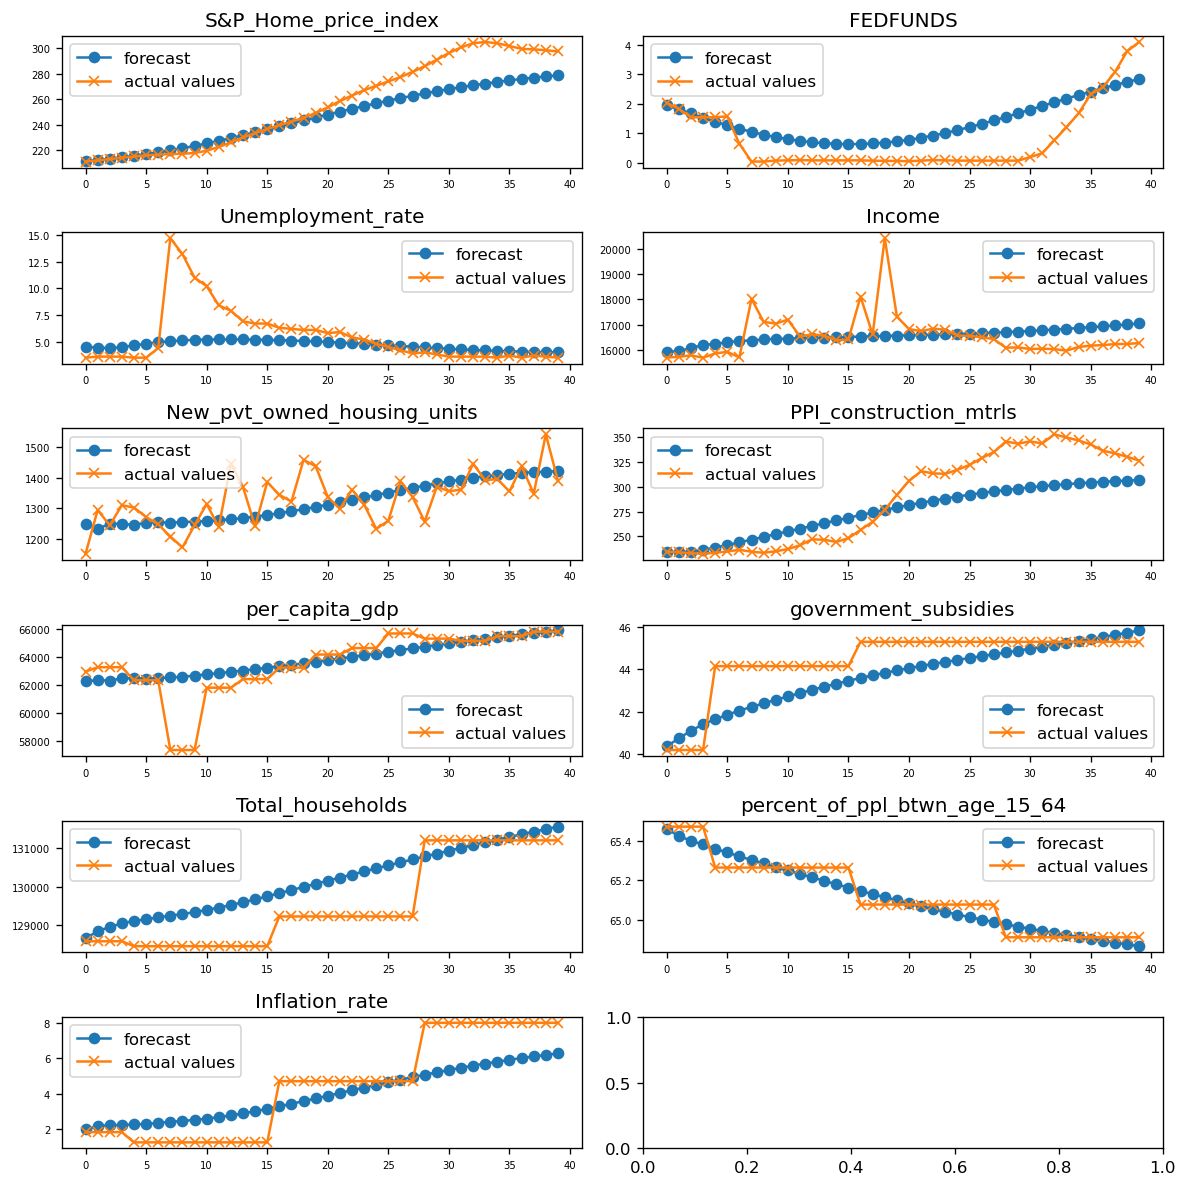

In [71]:
def plot_forecast_actuals(data, data_actual, data_predict):
    fig, axes = plt.subplots(nrows=int(len(data_actual.columns)/2), ncols=2, dpi=120, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        ax.plot(data_predict[col], label='forecast', marker='o')
        ax.plot(data_actual[col], label='actual values', marker='x')
        ax.legend(loc='best')
        ax.set_title(data.columns[i])
        ax.set_title(col)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout();

plot_forecast_actuals(data=hpi_timeseries_data, data_actual=df_test.reset_index(), data_predict=predictions)


#### Now let's check the R2 score for each predicted column

In [73]:
R2_score_for_time_series ={'Feature':[],'R2 score':[]}
for col in df_test.columns:
    R2_score_for_time_series['Feature'].append(col)
    R2_score_for_time_series['R2 score'].append(r2_score(df_test[col],predictions[col]))

timeseries_perf_df = pd.DataFrame(R2_score_for_time_series)

In [74]:
timeseries_perf_df

,Feature,R2 score
0,S&P_Home_price_index,0.783388
1,FEDFUNDS,0.368349
2,Unemployment_rate,0.099159
3,Income,-0.076307
4,New_pvt_owned_housing_units,0.246789
5,PPI_construction_mtrls,0.649144
6,per_capita_gdp,0.504797
7,government_subsidies,0.422250
8,Total_households,0.496337
9,percent_of_ppl_btwn_age_15_64,0.916232


#### Our time series model predicts the S&P Home price index with an R2 score of 0.78.

# Conclusions:

### 1. All features show strong correlation with S&P home price index except,FEDFUNDS and New private owned housing units.

### 2. Linear Regression, Ridge Regression, Bayesian Ridge Regression, Lasso Regression perform well with the data with mean R2 scores of around 0.95 after cross validation.R2 score of these models decreases slightly after the removal of weakly correlated features from the data.

### 3. Granger Causality test shows that every feature is responsible in causing a change in S&P HPI.

### 4. A Basic VAR time series model works well to predict the future values of S&P HPI with an R2 score of 0.78.